In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import Normalizer

I used a dataset that contains player data from FIFA21. The objective of the project is to find relation between ‘ova’ (overall average) ,‘age’(age of player),'position','club' and ‘market_value‘ (market value is addition of columns ‘value ‘and ‘wage’)

 Statements:
-	As ‘ova’ increase market value of player also increase 
-	Maximin player have good ‘ova’ are between age group  25-40
-	value of player depend on club also , as “Paris Saint-Germain”  have highest paying  player , other  clubs player with same     ova have less value . 
-	Also player who can play on multiple position have more market value .


Final statement: market value of player depends upon players age, overall average, club which through player play and players position 


        name	       age	position	ova     club	              market_value
        
9331	K. Mbappé	    21	ST LW RW	90		Paris Saint-Germain	  105660000.0
2650	Neymar Jr       28	LW CAM	    91		Paris Saint-Germain	  90270000.0
2871	K. De Bruyne	29	CAM CM	    91		Manchester City	      87370000.0
2287	R. Lewandowski	31	ST	        91		FC Bayern München	  80240000.0
5109	M. Salah	    28	RW	        90		Liverpool	          78250000.0



## Fetching and formating of data

In [133]:
df = pd.read_csv(r'C:\Users\parag\Desktop\ironhack\lab\project\data_mid_bootcamp_project_FIFA_MoneyBall\fifa21_male2.csv')
df.columns = df.columns.str.lower().str.replace(' ','_')
df.drop_duplicates()
df.head()

,id,name,age,ova,nationality,club,bov,bp,position,player_photo,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,gender
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


In [134]:
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Data columns (total 107 columns):
 #    Column            Dtype  
---   ------            -----  
 0    id                int64  
 1    name              object 
 2    age               int64  
 3    ova               int64  
 4    nationality       object 
 5    club              object 
 6    bov               int64  
 7    bp                object 
 8    position          object 
 9    player_photo      object 
 10   club_logo         object 
 11   flag_photo        object 
 12   pot               int64  
 13   team_&_contract   object 
 14   height            object 
 15   weight            object 
 16   foot              object 
 17   growth            int64  
 18   joined            object 
 19   loan_date_end     object 
 20   value             object 
 21   wage              object 
 22   release_clause    object 
 23   contract          object 
 24   attacking         int64  
 25   crossing          in

In [135]:
#check nulls
df.isna().sum()

id             0
name           0
age            0
ova            0
nationality    0
              ..
cb             0
rcb            0
rb             0
gk             0
gender         0
Length: 107, dtype: int64

In [136]:
df.columns

Index(['id', 'name', 'age', 'ova', 'nationality', 'club', 'bov', 'bp',
       'position', 'player_photo',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'gender'],
      dtype='object', length=107)

# Selection of required columns only

In [137]:
df1 = df[[ 'name', 'age','position','ova','value','wage','club']]
df1.head()

,name,age,position,ova,value,wage,club
0,G. Pasquale,33,LM,69,€625K,€7K,Udinese
1,Luis García,37,CM CAM CDM,71,€600K,€7K,KAS Eupen
2,J. Cole,33,CAM RM RW LM,71,€1.1M,€15K,Coventry City
3,D. Yorke,36,NaN,68,€0,€0,Sunderland
4,Iniesta,36,CM CAM,81,€5.5M,€12K,Vissel Kobe


# Filter data as per requirement :
# Want to remove ‘'€’, ‘K’,’M’  from columns value, wage and change data type to float

In [138]:
def parse_money(s):
    if s.startswith('€'):
        s = s[1:]
    multiplier = None
    if s.endswith('M'):
        s = s[:-1]
        multiplier = 1000000
    elif s.endswith('B'):
        s = s[:-1]
        multiplier = 1000000000
    elif s.endswith('K'):
        s = s[:-1]
        multiplier = 1000
    f = float(s)
    if multiplier:
        f = f * multiplier
    return f



In [139]:
df1['value'] = df1['value'].apply(parse_money)
df1['wage'] = df1['wage'].apply(parse_money)
df1[['value', 'wage']].head()

,value,wage
0,625000.0,7000.0
1,600000.0,7000.0
2,1100000.0,15000.0
3,0.0,0.0
4,5500000.0,12000.0


Addition of value and wage to calculate total value of particular player

In [140]:
df1['market_value'] = df1['value'] + df1['wage'] 

In [141]:
df1.describe()

,age,ova,value,wage,market_value
count,17125.000000,17125.000000,1.712500e+04,17125.000000,1.712500e+04
mean,25.272934,66.965022,2.567377e+06,10532.928467,2.577910e+06
std,4.942665,6.864329,5.372622e+06,21145.376646,5.390033e+06
min,16.000000,38.000000,0.000000e+00,0.000000,0.000000e+00
25%,21.000000,62.000000,3.750000e+05,1000.000000,3.760000e+05
50%,25.000000,67.000000,8.000000e+05,3000.000000,8.030000e+05
75%,29.000000,72.000000,2.400000e+06,11000.000000,2.415000e+06
max,53.000000,93.000000,1.055000e+08,560000.000000,1.056600e+08


# Get the numeric data into dataframe called numerical and categorical columns in a dataframe called categoricals

In [142]:
numerical = df1.select_dtypes(include=np.number)
categoricals = df1.select_dtypes(include=np.object)
print('Numerical Data into dataframe:')
display(numerical.head())
print('Categorical Data into dataframe:')
display(categoricals.head())

Numerical Data into dataframe:


,age,ova,value,wage,market_value
0,33,69,625000.0,7000.0,632000.0
1,37,71,600000.0,7000.0,607000.0
2,33,71,1100000.0,15000.0,1115000.0
3,36,68,0.0,0.0,0.0
4,36,81,5500000.0,12000.0,5512000.0


Categorical Data into dataframe:


,name,position,club
0,G. Pasquale,LM,Udinese
1,Luis García,CM CAM CDM,KAS Eupen
2,J. Cole,CAM RM RW LM,Coventry City
3,D. Yorke,NaN,Sunderland
4,Iniesta,CM CAM,Vissel Kobe


# Scatter plotting graph to check relation between two columns

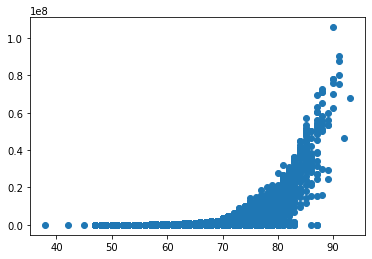

In [143]:
plt.scatter(df1['ova'], df1['market_value'])
plt.show()

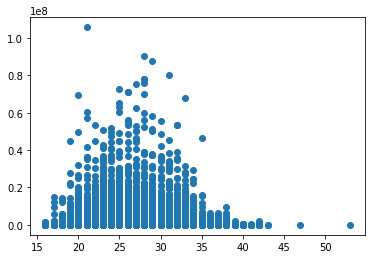

In [144]:
plt.scatter(df1['age'], df1['market_value'])
plt.show()

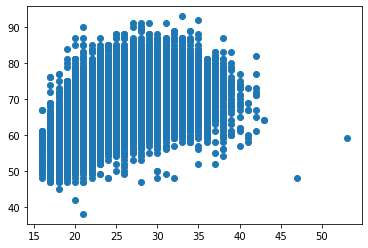

In [145]:
plt.scatter(df1['age'], df1['ova'])
plt.show()

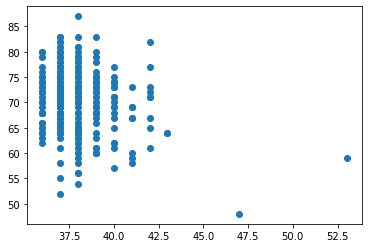

In [174]:
test = df1.sort_values(['age'], ascending=False)
test_sort1=test.head(300)
plt.scatter(test_sort1['age'], test_sort1['ova'])
plt.show()

# top 10 player with  highest market value 

In [146]:
test = df1.sort_values(['market_value'], ascending=False)
test_sort=test.head(10)
test_sort

,name,age,position,ova,value,wage,club,market_value
9331,K. Mbappé,21,ST LW RW,90,105500000.0,160000.0,Paris Saint-Germain,105660000.0
2650,Neymar Jr,28,LW CAM,91,90000000.0,270000.0,Paris Saint-Germain,90270000.0
2871,K. De Bruyne,29,CAM CM,91,87000000.0,370000.0,Manchester City,87370000.0
2287,R. Lewandowski,31,ST,91,80000000.0,240000.0,FC Bayern München,80240000.0
5109,M. Salah,28,RW,90,78000000.0,250000.0,Liverpool,78250000.0
5030,S. Mané,28,LW,90,78000000.0,250000.0,Liverpool,78250000.0
4166,V. van Dijk,28,CB,90,75500000.0,210000.0,Liverpool,75710000.0
3665,J. Oblak,27,GK,91,75000000.0,125000.0,Atlético Madrid,75125000.0
4049,R. Sterling,25,LW RW,88,72500000.0,270000.0,Manchester City,72770000.0
3961,H. Kane,26,ST,88,71000000.0,220000.0,Tottenham Hotspur,71220000.0


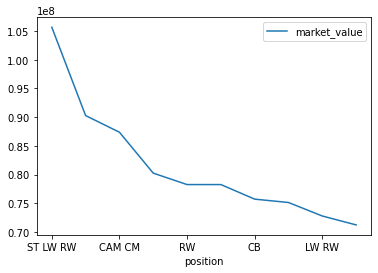

In [171]:
test_sort.plot(x='position', y='market_value')
plt.show()

# correlations betwwen age , ova, total_vale 

In [191]:
test_data = df1[[  'age', 'ova', 'market_value']]
test_data.head()

,age,ova,market_value
0,33,69,632000.0
1,37,71,607000.0
2,33,71,1115000.0
3,36,68,0.0
4,36,81,5512000.0


In [192]:
corr_data = test_data.corr() # With standard method 'pearson'
corr_matrix = corr_data.corr()
corr_matrix

,age,ova,market_value
age,1.000000,-0.266193,-0.997767
ova,-0.266193,1.000000,0.329981
market_value,-0.997767,0.329981,1.000000


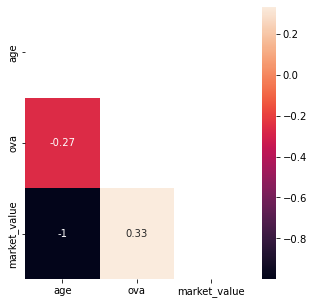

In [193]:
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True) 
plt.show()

# Analyzing Results

In [185]:
## encoding categorical
demo = pd.get_dummies(numerical, drop_first=True)

In [186]:
#effective_to_date encoding
# X-y split.
X = demo.drop(['market_value'], axis=1)#effective_to_date is target
y = demo['market_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [187]:
#LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [188]:
predictions = model.predict(X_test)
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(1.0, 1.6480609541317184e-09, 2.121031011120857e-09)

# Graphical presentation of prediction 

<AxesSubplot:xlabel='market_value'>

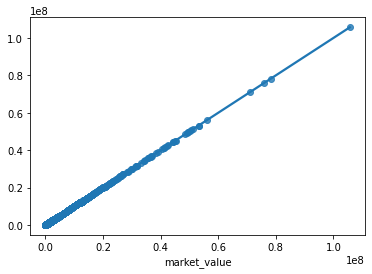

In [189]:
sns.regplot(y_test,predictions)